# CNN Image Classification Laboration


Images used in this laboration are from [CIFAR10](https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 

Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

Complete the code flagged throughout the elaboration and **answer all the questions in the notebook**.

In [1]:
# Setups
# Automatically reload modules when changed
%reload_ext autoreload
%autoreload 2

# Part 1: Convolutions

In the next sections you will familiarize yourself with 2D convolutions.

## 1.1 What is a convolution?

To understand a bit more about convolutions, we will first test the convolution function in `scipy` using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function `convolve2d` in `signal` from scipy (see the [documentation](https://docs.scipy.org/doc/scipy-1.15.0/reference/generated/scipy.signal.convolve2d.html
) for more details).


In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation (which is in contrast to traditional image processing, where the filters are designed by an expert).

Run the cell below to define a Gaussian filter and a Sobel X and Y filters.

In [2]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import datasets
image = datasets.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [3]:
# --------------------------------------------
# === Your code here =========================
# -------------------------------------------- 
from scipy.signal import convolve2d

# Perform convolution using the function 'convolve2d' for the different filters

filterResponseGauss  = convolve2d(image, gaussFilter, mode="same", boundary="symm")
filterResponseSobelX = convolve2d(image, sobelX,      mode="same", boundary="symm")
filterResponseSobelY = convolve2d(image, sobelY,      mode="same", boundary="symm")

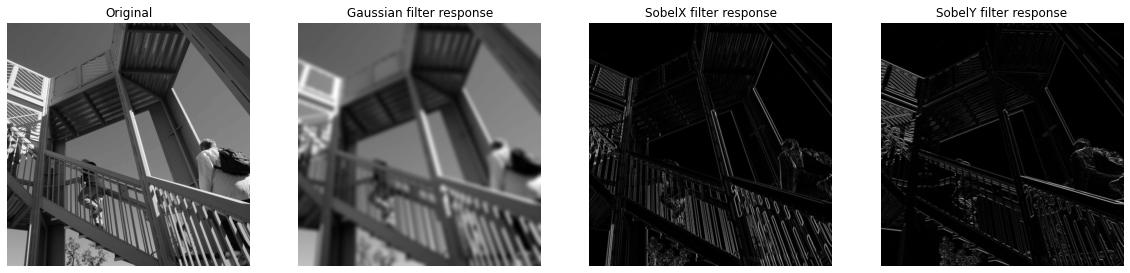

In [4]:
import matplotlib.pyplot as plt

# Show filter responses
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Gaussian filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('SobelX filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('SobelY filter response')
ax_filt3.set_axis_off()

## 1.2 Understanding convolutions

#### **<span style="color:red">Questions</span>**

1. What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

2. What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

3. What is the size of the different filters?

4. What is the size of the filter response if mode 'same' is used for the convolution ?

5. What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

6. Why are 'valid' convolutions a problem for CNNs with many layers?

#### **<span style="color:green">Answers</span>**
1. Gaussian - Gaussian blurring. SobelX - detects vertical edges. SobelY - horizontal edges
2. 512x512, 1 channel. A color image normally has 3 channels and sometimes an extra one, alpha, for transparency (e.g. .png images)
3. Gaussian: 15x15, Sobel: 3x3
4. Same as the original image
5. With mode='valid', the convolution output contains only positions where the filter/kernel lies entirely inside the input (no padding), so the response is smaller than the input.Keeping the image size fixed, increasing the filter size shrinks the valid output linearly in each dimension: each time we increase filter size by 1, the output height (or width) decreases by 1.
6. Every convolution shrinks the spatial dimensions, so in a deep CNN the feature maps can become tiny (or even hit zero/negative size) after just a few layers - especially if we also downsample with pooling/strides. Border information is also lost at every layer.


In [6]:
# --------------------------------------------
# === Your code here =========================
# -------------------------------------------- 
# Your code for checking sizes of image and filter responses
print(image.shape)
print(convolve2d(image, gaussFilter, mode="valid").shape)
# ============================================

(512, 512)
(498, 498)


#  Part 2: Get a graphics card

Skip the next cell if you run on the CPU.

If your computer has a dedicated graphics card and you would like to use it, we need to make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming calculations in every training iteration.

In [7]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# This sets the GPU to allocate memory only as needed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) != 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True) 
    print("Running on GPU")
else:
    print('No GPU available.')

Running on GPU


## How fast is the graphics card?


#### **<span style="color:red">Questions</span>**

7. Why are the filters used for a color image of size 7 x 7 x 3, and not 7 x 7 ? 

8. What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

9.  Pretend that everyone is using an Nvidia RTX 3090 graphics card, how many CUDA cores does it have? How much memory does the graphics card have?

10. How much memory does the graphics card have?

11. What is stored in the GPU memory while training a CNN?

12. Do you think that a graphics card, compared to the CPU, is equally faster for convolving a batch of 1,000 images, compared to convolving a batch of 3 images? Motivate your answer.


#### **<span style="color:green">Answers</span>**
7. Filters need to use inputs from each input channel.
8. Conceptually they’re closely related (a sliding dot product), but Conv2D is the multi-channel, multi-filter, learned version and is usually cross-correlation rather than strict convolution.
9. An Nvidia GeForce RTX 3090 has 10,496 CUDA cores and 24 GB of GDDR6X VRAM.
10. 24 GB of GDDR6X VRAM
11. Model parameters, gradients, optimizer state, intermediate activations (feature maps), current batch of input data (and labels), framework/library workspace and caches
12. With very small batches, fixed overheads (kernel launches, CPU↔GPU scheduling, data movement) take a larger fraction of total time, so the GPU can be underutilized and the speedup over CPU can shrink. So with 1000 images, GPU is much faster than CPU.


# Part 3: Dataset

In the following section you will load the CIFAR10 dataset, check few samples, perform some preprocessing on the images and the labels, and split the data into training, validation and testing.

## 3.1 Load the dataset

Run the following section to load the CIFAR10 data, take a total of 10.000 training/validation samples and 2000 testing samples. 

In [8]:
import tensorflow as tf
try:
    import tf_keras as keras
    USING_TF_KERAS_PKG = True
except ImportError:
    from tensorflow import keras
    USING_TF_KERAS_PKG = False
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(X, Y), (Xtest, Ytest) = cifar10.load_data()

print("Training/validation images have size {} and labels have size {} ".format(X.shape, Y.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training/validation and testing to 10000 and 2000 respectively, 
# to reduce processing time for this elaboration. 
X = X[0:10000]
Y = Y[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training/validation images have size %s and labels have size %s " % (X.shape, Y.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training/validation examples for class {} is {}" .format(i,np.sum(Y == i)))

170498071/170498071 [==============================] - 19s 0us/step
Training/validation images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training/validation images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training/validation examples for class 0 is 1005
Number of training/validation examples for class 1 is 974
Number of training/validation examples for class 2 is 1032
Number of training/validation examples for class 3 is 1016
Number of training/validation examples for class 4 is 999
Number of training/validation examples for class 5 is 937
Number of training/validation examples for class 6 is 1030
Number of training/validation examples for class 7 is 1001
Number of training/validation examples for class 8 is 1025
Number of training/validation examples for class 9 is 981


Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

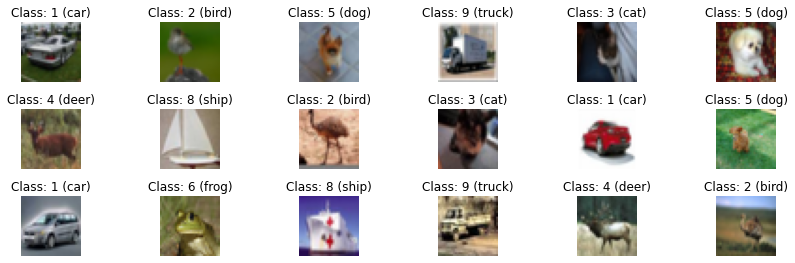

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Y[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(X[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##  3.2 Split data into training, validation and testing
Split your data (X, Y) into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration).

We use the `train_test_split` function from scikit learn (see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for more details) to obtain 25% validation set.

In [10]:
from sklearn.model_selection import train_test_split

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# split the original dataset into 70% Training and 30% Temp
Xtrain, Xval, Ytrain, Yval = train_test_split(
    X, Y,
    test_size=0.25,
    random_state=123,
    shuffle=True,
    stratify=Y
)



# Print the size of training data, validation data and test data
print("Xtrain:", Xtrain.shape, "Ytrain:", Ytrain.shape)
print("Xval:  ", Xval.shape,   "Yval:  ", Yval.shape)

# ============================================

Xtrain: (7500, 32, 32, 3) Ytrain: (7500, 1)
Xval:   (2500, 32, 32, 3) Yval:   (2500, 1)


## 3.3 Image Preprocessing

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255.

In [11]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  3.4 Label preprocessing

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use the `to_categorical`function in Keras (see the [documentation](https://keras.io/api/utils/python_utils/#to_categorical-function) for details on how to use it)

In [12]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print('Ytrain has size {}.'.format(Ytrain.shape))
print('Yval has size {}.'.format(Yval.shape))
print('Ytest has size {}.'.format(Ytest.shape))


# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain_ids = Ytrain.squeeze()
Yval_ids   = Yval.squeeze()
Ytest_ids  = Ytest.squeeze()
num_classes = int(np.max(Ytrain_ids)) + 1
Ytrain = to_categorical(Ytrain_ids, num_classes=num_classes)
Yval   = to_categorical(Yval_ids,   num_classes=num_classes)
Ytest  = to_categorical(Ytest_ids,  num_classes=num_classes)

# Print shapes after converting the labels
print('Ytrain has size {}.'.format(Ytrain.shape))
print('Yval has size {}.'.format(Yval.shape))
print('Ytest has size {}.'.format(Ytest.shape))

# ============================================

Ytrain has size (7500, 1).
Yval has size (2500, 1).
Ytest has size (2000, 1).
Ytrain has size (7500, 10).
Yval has size (2500, 10).
Ytest has size (2000, 10).


# Part 4: 2D CNN

In the following sections you will build a 2D CNN model and will train it to perform classification on the CIFAR10 dataset. 

## 4.1 Build CNN model

Start by implementing the `build_CNN` function in the `utilities.py` file. Below you can find the specifications on how your `build_CNN` function should build the model:
- Each convolutional layer is composed by: `2D convolution` -> `batch normalization` -> `max pooling`.
- The `2D convolution` uses a 3 x 3 kernel size, padding='same' and a number of starting filter that is an input to the `build_CNN` function. The number of filters doubles with each convolutional layer (e.g. 32, 64, 128, etc.)
- The max pooling layers should have a pool size of 2 x 2.
- After the convolutional layers comes a flatten layer, followed by a number of intermediate dense layers. 
- The number of nodes in the intermediate dense layers before the final dense layer is an input to the `build_CNN` function. The intermediate dense layers use `relu` activation functions and each is followed by `batch normalization`.
- The final dense layer should have 10 nodes (=the number of classes in this elaboration) and `softmax` activation. 

Here are some relevant functions that you should use in `build_CNN`. For a complete list of functions and their definitions see the [keras documentation](https://keras.io/api/):

- `model.add()`, adds a layer to the network;
- `Dense()`, a dense network layer. See the [documentation](https://keras.io/api/layers/core_layers/dense/) what are the input options and outputs of the `Dense()` function. 
- `Conv2D()` performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3) (see [documentation](https://keras.io/api/layers/convolution_layers/convolution2d/)). 
- `BatchNormalization()`, perform batch normalization (see [documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/)).
- `MaxPooling2D()`, saves the max for a given pool size, results in down sampling (see [documentation](https://keras.io/api/layers/pooling_layers/max_pooling2d/)).
- `Flatten()`, flatten a multi-channel tensor into a long vector (see [documentation](https://keras.io/api/layers/reshaping_layers/flatten/)).
- `model.compile()`, compiles the model. You can set the input metrics=['accuracy'] to print the classification accuracy during the training.
- cost and loss functions: check the [documentation](https://keras.io/losses/) and chose a loss function for binary classification.

To get more information in model [compile](https://keras.io/api/models/model_training_apis/#compile-method), [training](https://keras.io/api/models/model_training_apis/#fit-method) and [evaluation](https://keras.io/api/models/model_training_apis/#evaluate-method) see the relevant documentation.

Here you can start with the `Adam` optimizer when compiling the model.

Use the following cell to test your `build_CNN` utility function. Remember to import a relevant cost function for multi-class classification from [keras.losses](https://keras.io/losses/) which relates to how many classes you have.

In [13]:
# import utilities
from utilities import build_CNN

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# import a suitable loss function from keras.losses and use as input to the build_DNN function.
loss = keras.losses.CategoricalCrossentropy()

# Build a DNN model following the specifications above
model = build_CNN(
    input_shape=Xtrain.shape[1:],   # e.g. (H, W, C)
    loss=loss,
    n_conv_layers=3,
    n_filters=32,                   # starting filters
    n_dense_layers=2,
    n_nodes=128,
    optimizer="adam",
    learning_rate=1e-3,
    print_summary=True
)

# ============================================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                        

In [14]:
model.layers[0].kernel_size, model.layers[3].kernel_size, model.layers[6].kernel_size

((3, 3), (3, 3), (3, 3))

## 4.2 Train 2D CNN

Time to train the CNN!

Start with a model with 2 convolutional layers where the first layer has have 16 filters, and with no intermediate dense layers.

Set the training parameters, build the model and run the training. 

Use the following training parameters:
- `batch_size=20`
- `epochs=20`
- `learning_rate=0.01`

Relevant functions:
- `build_CNN`, the function that you defined in the `utilities.py` file.
- `model.fit()`, train the model with some training data (see [documentation](https://keras.io/api/models/model_training_apis/#fit-method)).
- `model.evaluate()`, apply the trained model to some test data (see [documentation](https://keras.io/api/models/model_training_apis/#evaluate-method)).

## 2 convolutional layers, no intermediate dense layers

In [15]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training parameters
batch_size = 20
epochs = 20
input_shape = Xtrain.shape[1:]
learning_rate = 0.01

# Build model
model1 = model

# Train the model  using training data and validation data
history1 = model1.fit(
    Xtrain, Ytrain,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(Xval, Yval),
    verbose=1
)

# ============================================

Epoch 1/20
375/375 [==============================] - 13s 10ms/step - loss: 1.7183 - accuracy: 0.3900 - val_loss: 1.6871 - val_accuracy: 0.3840
Epoch 2/20
375/375 [==============================] - 4s 10ms/step - loss: 1.3530 - accuracy: 0.5193 - val_loss: 1.3940 - val_accuracy: 0.5032
Epoch 3/20
375/375 [==============================] - 4s 10ms/step - loss: 1.1851 - accuracy: 0.5781 - val_loss: 1.3891 - val_accuracy: 0.5332
Epoch 4/20
375/375 [==============================] - 4s 9ms/step - loss: 1.0227 - accuracy: 0.6428 - val_loss: 1.3858 - val_accuracy: 0.5448
Epoch 5/20
375/375 [==============================] - 4s 9ms/step - loss: 0.8859 - accuracy: 0.6920 - val_loss: 1.4807 - val_accuracy: 0.5312
Epoch 6/20
375/375 [==============================] - 4s 10ms/step - loss: 0.7382 - accuracy: 0.7427 - val_loss: 1.2806 - val_accuracy: 0.5876
Epoch 7/20
375/375 [==============================] - 4s 10ms/step - loss: 0.6380 - accuracy: 0.7809 - val_loss: 1.4178 - val_accuracy: 0.5716


In [16]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Evaluate the trained model on test set, not used in training or validation
score = model1.evaluate(Xtest, Ytest, verbose=1)

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

63/63 [==============================] - 1s 5ms/step - loss: 2.6976 - accuracy: 0.5430
Test loss: 2.6976
Test accuracy: 0.5430


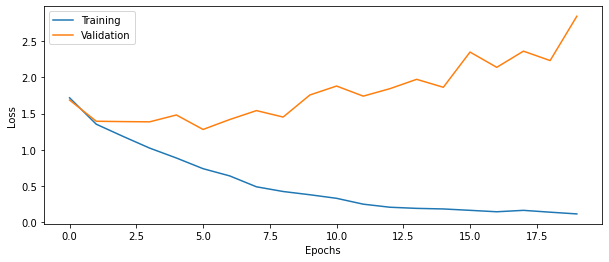

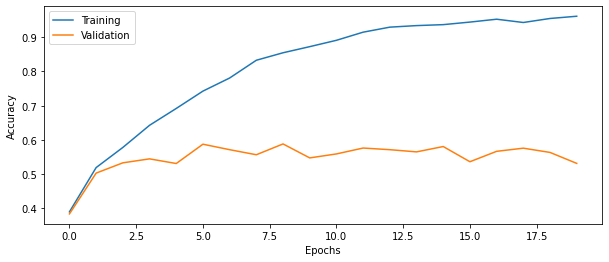

In [17]:
from utilities import plot_results
# Plot the history from the training run
plot_results(history1)

##  4.3 Improving model performance

Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%)? 

#### **<span style="color:red">Questions</span>**
13. How big is the difference between training and test accuracy?

14. For the DNN elaboration we used a batch size of 10.000, why do we need to use a smaller batch size in this elaboration?

#### **<span style="color:green">Answers</span>**
[Your answer here]

Experiment with several model configurations in the following sections. 

### 2 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes)

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Build and train model
model1 = ???

history1 = ???

# Evaluate model on test data
score = ???

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history1)

### 4 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes)

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Build and train model
model2 = ???

history2 = ???

# Evaluate model on test data
score = ???

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history2)

## 4.4 Plot the CNN architecture and understand the internal model dimensions

To understand your network better, print the architecture using `model.summary()`

#### **<span style="color:red">Questions</span>**

15. How many trainable parameters does your network have? Which part of the network contains most of the parameters?
    
16. What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 
17. Is the batch size always the first dimension of each 4D tensor? Check the [documentation](https://keras.io/layers/convolutional/) for Conv2D.
18. If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?
19. Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?
20. How does MaxPooling help in reducing the number of parameters to train?

#### **<span style="color:green">Answers</span>**
[Your answer here]

##  4.5 Dropout regularization

Add dropout regularization between each intermediate dense layer, with dropout probability 50%.

#### **<span style="color:red">Questions</span>**

21. How much did the test accuracy improve with dropout, compared to without dropout?

22. What other types of regularization can be applied? How can you add `L2 regularization` for the convolutional layers?
 
#### **<span style="color:green">Answers</span>**
[Your answer here]


### 4 convolutional layers with 16 starting filters and 1 intermediate dense layer (50 nodes) with dropout

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training parameters
batch_size = ???
epochs = ???
input_shape = ???
learning_rate = ???

# Build and train model
model3 = ???

# Train the model using training data and validation data
history3 = ???

# Evaluate model on test data
score = ???

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

plot_results(history3)

##  4.6 Tweaking model performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

#### **<span style="color:red">Questions</span>**

23. How high test accuracy can you obtain? What is your best configuration?

#### **<span style="color:green">Answers</span>**
[Your answer here]

## *Your best config*

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup some training parameters
batch_size = ???
epochs = ???
input_shape = ???
learning_rate = ???

# Build and train model. Here experiment with several model architecture configurations to obtain the best performance.
model4 = ???

history4 = ???

# Evaluate model on test data
score = ???

# ============================================

print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Plot the history from the training run
plot_results(history4)

# Part 5: Model generalization

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

#### **<span style="color:red">Questions</span>**

24. What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

#### **<span style="color:green">Answers</span>**
[Your answer here]

In [ ]:
from utilities import myrotate
# Visualize some rotated images
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [ ]:
# Evaluate the trained model on rotated test set
score = model4.evaluate(Xtest_rotated, Ytest, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

##  5.1 Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`. In particular, we will use the `flow()` functionality (see the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for more details).

Make sure to use different subsets for training and validation when you calling `flow()` on the training data generator in `model.fit()`, otherwise you will validate on the same data. 

In [ ]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own

# re-load the CIFAR10 train and test data
(X, Y), (Xtest, Ytest) = cifar10.load_data()

# Reduce the number of images for training/validation and testing to 10000 and 2000 respectively, 
# to reduce processing time for this elaboration. 
X = X[0:10000]
Y = Y[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

# Change data type and rescale range
X = X.astype('float32')
Xtest = Xtest.astype('float32')

X = X / 127.5 - 1
Xtest = Xtest / 127.5 - 1


# Convert labels to hot encoding
Y = to_categorical(Y, 10)
Ytest = to_categorical(Ytest, 10)

print("Training/validation images have size {} and labels have size {} ".format(X.shape, Y.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

In [92]:
from tf_keras.preprocessing.image import ImageDataGenerator

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Use a rotation range of 30 degrees, horizontal and vertical flipping
# Set up image data generator
image_dataset = ImageDataGenerator(???)


# ============================================


#### **<span style="color:red">Questions</span>**

25. How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

#### **<span style="color:green">Answers</span>**
[Your answer here]

In [ ]:
# Plot some augmented images

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = train_flow.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## 5.2 Train the CNN with images from the generator

Check the documentation for the [`model.fit`](https://keras.io/api/models/model_training_apis/#fit-method) method how to use it with a generator instead of a fix dataset (numpy arrays).

To make the comparison fair to training without augmentation

- `steps_per_epoch` should be set to: `len(Xtrain)/batch_size`
- `validation_steps` should be set to: `len(Xval)/batch_size`
    
This is required since with a generator, the fit function will not know how many examples your original dataset has.

#### **<span style="color:red">Questions</span>**

26. How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. We are here talking about the number of training epochs required to reach a certain accuracy, and not the training time in seconds. What parameter is necessary to change to perform more training?

27. What other types of image augmentation can be applied, compared to what we use here?

#### **<span style="color:green">Answers</span>**
[Your answer here]

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------

# Setup training parameters
batch_size = ???
epochs = ???
input_shape = ???

# Build model (your best config)
model6 = build_CNN(???)

# Set up training and validation dataset flows from image_dataset
# flow() for training data
train_flow = image_dataset.flow(???)

# flow() for validation data
val_flow = image_dataset.flow(???)


# Train the model using on the fly augmentation
history6 = model6.fit(???)

# ============================================

In [ ]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

In [ ]:
# Plot the history from the training run
plot_results(history6)

## Plot misclassified images

Lets plot some images where the CNN performed badly.

In [97]:
# Find misclassified images
y_pred=model6.predict(Xtest, verbose=0) 
y_pred=np.argmax(y_pred,axis=1)

y_correct = np.argmax(Ytest,axis=-1)

miss = np.flatnonzero(y_correct != y_pred)

In [ ]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  5.3 Testing on another size

#### **<span style="color:red">Questions</span>**

28. This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

29. Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

#### **<span style="color:green">Answers</span>**
[Your answer here]

# Part 6: Carbon footprint

In this next section we will evaluate the carbon footprint of training our CNN model. In particular we will look at the effect of training hyper parameters of carbon footprint. You can read more about this topic [here](https://arxiv.org/abs/2007.03051) or [here](https://research.google/blog/good-news-about-the-carbon-footprint-of-machine-learning-training/). 

In this lab we will use the `carbontracker` library that easily integrates with any model training routine. See the example in the [documentation](https://github.com/lfwa/carbontracker?tab=readme-ov-file) on how to use the carbon tracker.

#### **<span style="color:red">Questions</span>**

28. Keeping the model architecture fixed, which training parameter impacts the carbon footprint? 
    
29. The choice of batch size can dramatically impact carbon foot print: why is this the case?
    
30. Assume that you have a model with 100 million parameters running in the backend of a service with 5 million users. How can the carbon footprint of using this model be reduced?

#### **<span style="color:green">Answers</span>**
[Your answer here]

In [ ]:
from carbontracker.tracker import CarbonTracker

# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# Setup training parameters
batch_size = ???
epochs = ???
input_shape = ???

# Build model (your best config)
model7 = ???

# Create a CarbonTracker object
tracker = CarbonTracker(epochs=???)

# start carbon tracking
tracker.epoch_start()

# fit model
model.fit(???)

tracker.epoch_end()

# ============================================


# Part 7: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database (several million images, 1000 classes). Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

#### **<span style="color:red">Questions</span>**

31. How many convolutional layers does ResNet50 have? 

32. How many trainable parameters does the ResNet50 network have? 

33. What is the size of the images that ResNet50 expects as input?

34. Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

35. What do you expect the carbon footprint of using pre-trained networks to be compared to training a model from scratch?

#### **<span style="color:green">Answers</span>**
[Your answer here]


After loading the pre-trained CNN, apply it to 5 random color images that you download and copy to the cloud machine or your own computer. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this elaboration.

Some useful functions:
- `load_img` and `img_to_array` in [tf_keras.utils](https://www.tensorflow.org/api_docs/python/tf/keras/utils).
- `ResNet50` in [tf_keras.applications.ResNet50](tf.keras.applications.ResNet50).
- `preprocess_input` in [tf_keras.applications.resnet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/preprocess_input).
- `decode_predictions` in [tf_keras.applications.resnet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet/decode_predictions).
- `expand_dims` in [numpy](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html).

See [keras applications](https://keras.io/api/applications/) and the keras [resnet50-function](https://keras.io/api/applications/resnet/#resnet50-function) for more details.

In [ ]:
# --------------------------------------------
# === Your code here =========================
# --------------------------------------------
# import the necessary libraries and functions 
from tf_keras.applications import ???
from tf_keras.utils import ???, ???
from tf_keras.applications.resnet import ???, ???

# load the pre-trained ResNet50 model
resnet50 = ???

# print the model summary
???

# load the image and preprocess it
image = ???

# predict the image
label = ???

# print the predicted label
print(label)

# ============================================

# Part 8 (OPTIONAL)

Set up `Ray Tune` and run automatic hyper parameter optimization for the CNN model as we have done in the DNN lab. Remember that you have to define the `train_CNN` function, specify the hyper parameter search space and the number of samples to evaluate, among other.